# Synopsis:

#### Introduction and Objective
The purpose of this project is to analyze the daily sales and product sales history for an unnamed Vietnamese restaurant in the Inland Empire of California. We will recreate a POS dashboard which visualizes KPIs and metrics (such as daily/monthly sales, hourly sales heatmaps, and forecasting), suggest methods for reduction of menu itemization while minimizing profit loss, and suggest item price adjustments to increase profit. Also as an observational aside, we will determine whether or not tip amounts are statistically higher immediately after the onset of the COVID-19 pandemic.

#### Conclusion
As a final result of our sales analysis, we were able to successfully

- **Reduce menu size** by condensing appetizer choices which saw a
    - **12.5% increase in sales** for Egg Rolls
    - **4.96% increase in sales** for Chicken Skewers
- **Adjust pricing** for rice and salad dishes in which only the **Saigon Rice Plate** saw significant positive changes such as a
    - **\\$822.85 increase in sales**
    - **95 increase in quantity sold**
    
Also using inferential statistics, we were able to determine that **tip proportions are significantly (p < 0.001) higher** post-COVID pandemic than pre-COVID pandemic, as intuitively expected.
 
#### Methods Used
- Data Cleaning
- Data Visualization
- Hypothesis Testing

#### Technologies
Python and associated packages such as `Pandas`, `Matplotlib`, `Seaborn`, and `SciPy`.

#### Contributors
- Jared Thach - github/jared8thach
- Anonymous Vietnamese restaurant located in the Inland Empire

***

# Table of Contents

- 1) <a href='#Sec 1'>Importing Libraries</a> 
- 2) <a href='#Sec 2'>Data Cleaning / Pre-Processing</a>
- 3) <a href='#Sec 3'>EDA / Restaurant Dashboard</a> 
    - <a href='#Sec 3-1'>Monthly Sales Growth</a>
    - <a href='#Sec 3-2'>Forecasting Monthly Sales</a>
    - <a href='#Sec 3-3'>Heatmap of Average Number of Sales by Hour of the Week</a>
    - <a href='#Sec 3-4'>Heatmap of Average Total Sales by Hour of the Week</a>
- 4) <a href='#Sec 4'>Restaurant Analysis</a>
    - a) <a href='#Sec 4-1'>Reducing Menu Size</a>
    - b) <a href='#Sec 4-2'>Price Changes</a>
    - c) <a href='#Sec 4-3'>Customer Tip Before and After COVID-19 (Hypothesis Testing)</a>
- 5) <a href='#Sec 5'>Conclusion</a>

# 1) <a id='Sec 1'>Importing Libraries</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# 2) <a id='Sec 2'>Data Cleaning / Pre-Processing</a>

Before conducting any form of exploratory data analysis or sales analysis, we must clean our dataset.

In [2]:
def clean_daily(df):
    
    # saving the dataframe to a variable to return a clean copy without manipulating the actual dataset
    temp = df.copy()
    
    # converting `Date Time` to datetime object for easier manipulation
    temp['Date Time'] = temp['Date Time'].apply(lambda x: pd.to_datetime(x).date())

    # dropping `Unnamed: 1` because it is an entirely null column
    temp = temp.drop('Unnamed: 1', axis=1)

    # dropping `Total Sales (Other Types)` because Lantern does not accept any other forms of sales in store
    temp = temp.drop('Total Sales (Other Types)', axis=1)

    # dropping `Service charges (Tax include)` because Lantern has no service charges
    temp = temp.drop('Service charges (Tax include)', axis=1)

    # dropping `Total Sales + SC` because Lantern has no services charges, and therefore, this column is identical to `Total Sales`
    temp = temp.drop('Total Sales + SC', axis=1)

    # dropping `Paid Balance` because Lantern does not use this feature
    temp = temp.drop('Paid Balance', axis=1)

    # finally, we will rename some columns to be less verbose
    temp = temp.rename(
        {'Date Time': 'Date', 
         'Total Sales': 'Sales',
         'Total Sales (Cash)': 'Cash', 
         'Total Sales (Credit Card)': 'Card', 
         'Total Sales + SC + Tips': 'Sales + Tips'},
        axis=1
    )
    
    return temp

daily_df = pd.read_csv('.\data\Daily Sales Breakdown 01-01-2020 to 01-31-2021.csv', thousands=',')
daily_df = clean_daily(daily_df)
daily_df.head()

,Date,Non Taxable,Taxable,Discount,Tax,Sales,Cash,Card,Tips,Sales + Tips
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def clean_hour(df):
    
    temp = df.copy()
    
    temp = temp[['Receipt #', 'Date', 'By', 'Total']]
    
    temp['Date'] = pd.to_datetime(temp['Date'])
    
    # getting day
    day = temp['Date'].apply(lambda x: x.weekday())
    temp = temp.assign(**{'Day': day})
    
    # getting hour
    hour = temp['Date'].apply(lambda x: x.hour)
    temp = temp.assign(**{'Hour': hour})
    
    # getting rows after COVID
    temp = temp[temp['Date'].apply(lambda x: x.date()) > pd.to_datetime('2020-05-28')]
    
    return temp.reset_index(drop=True)

hour_df = pd.read_csv('.\data\Sales Report - By Hour 01-01-2020 To 01-30-2021.csv', converters={'By': str})
hour_df = clean_hour(hour_df)
hour_df.head()

,Receipt #,Date,By,Total,Day,Hour
0,5585,2020-05-29 10:26:00,6005,2.56,4,10
1,5586,2020-05-29 10:29:00,6005,1.13,4,10
2,5587,2020-05-29 11:41:00,6005,10.00,4,11
3,5588,2020-05-29 11:43:00,6005,19.74,4,11
4,5589,2020-05-29 11:46:00,6005,5.33,4,11


In [4]:
def clean_mod(df, month):
    
    temp = df.copy()
    
    # dropping `Qty`
    temp = temp.drop('Qty', axis=1)
    
    # renaming rows
    temp.loc[0, 'Appetizers'] = 'Egg Rolls (3)'
    temp.loc[2, 'Appetizers'] = 'Egg Rolls (2)'
    temp.loc[4, 'Appetizers'] = 'Chicken Skewers (3)'
    temp.loc[6, 'Appetizers'] = 'Chicken Skewers (2)'
    temp.loc[8, 'Appetizers'] = 'Firecracker Shrimp (4)'
    temp.loc[10, 'Appetizers'] = 'Firecracker Shrimp (7)'
    
    # dropping all rows that do not contain pattern
    temp = temp[temp['Appetizers'].str.contains('Egg|Chicken|Firecracker')]
    temp = temp.iloc[range(0,len(temp),2),]
    
    # cleaning `Total` column
    def clean_total(val):
        val = val.replace(',','')
        return float(val)
    temp['Total'] = temp['Total'].apply(clean_total)
    
    # adding `Month` Column
    temp = temp.assign(**{'Month': pd.to_datetime('{}-01-2020'.format(month))})
    
    return temp

mod_df = pd.DataFrame()

# iterating through our 3 csv's from September 2020 to November 2020
for i in ('09','10','11'):
    
    # cleaning and joining each month's modifiers
    temp = pd.read_csv('.\data\Modifiers {}-01-2020.csv'.format(i))
    mod_df = pd.concat([mod_df, clean_mod(temp, month=i)])

mod_df = mod_df.reset_index(drop=True)
mod_df = mod_df.groupby(['Appetizers', 'Month'])['Appetizers', 'Total'].agg('sum').reset_index()
mod_df.head()

,Appetizers,Month,Total
0,Chicken Skewers (2),2020-09-01,430.90
1,Chicken Skewers (2),2020-10-01,429.86
2,Chicken Skewers (2),2020-11-01,283.56
3,Chicken Skewers (3),2020-09-01,668.57
4,Chicken Skewers (3),2020-10-01,615.76


In [5]:
def clean_best(df):
    
    temp = df.copy()
    
    temp['Total (Tax included)'] = temp['Total (Tax included)'].str.replace(',','').astype(float)
    
    basil = temp.loc[temp['Description'].str.lower().str.contains('basil'),].sum()[2:]
    saigon = temp.loc[temp['Description'].str.lower().str.contains('saigon'),].sum()[2:]
    vermicelli = temp.loc[temp['Description'].str.lower().str.contains('salad'),].loc[temp['Description'].str.lower().str.contains('side') == 0,].sum()[2:]
    
#     pho = temp.loc[temp['Description'].str.lower().str.contains('pho'),]
#     banh_mi = temp.loc[temp['Description'].str.lower().str.contains('banh'),]

    temp = pd.DataFrame({'Spicy Basil': basil, 'Saigon Rice Plate': saigon, 'Vermicelli Salad': vermicelli})
    temp = temp.T.rename(columns={'Total (Tax included)': 'Total'})
    temp = temp.assign(**{'Item': temp.index}).reset_index(drop=True)
    
    return temp

best_df = pd.DataFrame()

# iterating through our 5 csv's from July 2020 to November 2020
for i, j in zip(('07', '08', '09', '10', '11', '01'), ('2020', '2020', '2020', '2020', '2020', '2021')):
    
    # cleaning and joining each month's items
    temp = pd.read_csv('.\data\Best & Worst Sold Items {}-01-{}.csv'.format(i, j))
    temp = clean_best(temp)
    temp = temp.assign(**{'Month': pd.to_datetime(i + '-01-' + j)})
    
    best_df = pd.concat([best_df, temp]).reset_index(drop=True)
    
best_df.head()

,Qty,Total,Item,Month
0,71,1026.14,Spicy Basil,2020-07-01
1,30,418.5,Saigon Rice Plate,2020-07-01
2,118,1559.39,Vermicelli Salad,2020-07-01
3,67,997.25,Spicy Basil,2020-08-01
4,97,1332.32,Saigon Rice Plate,2020-08-01


# 3) <a id='Sec 3'>EDA / Restaurant Dashboard</a>

This particular restaurant opened for its first day of business on **January 11th 2020**. However, due to the unfortunate circumstances of COVID-19, this restaurant was prompted to close for a few months (between **March 16th 2020** and **May 28th 2020**), possibly thwarting its initial "Grand Opening" buzz as indicated by the low sales on its re-opening. Quickly plotting the entire sales history, we get the following:

#### Daily Sales

In [6]:
# having a look at our daily sales
daily_df.iloc[30:35,]

,Date,Non Taxable,Taxable,Discount,Tax,Sales,Cash,Card,Tips,Sales + Tips
30,2020-01-31,0.00,868.11,4.97,67.62,930.76,226.44,704.32,55.49,986.25
31,2020-02-01,1.91,1206.41,12.02,93.63,1289.93,361.02,928.91,61.27,1351.20
32,2020-02-02,5.00,843.23,12.61,65.11,900.73,236.62,664.11,42.18,942.91
33,2020-02-03,0.00,885.27,7.22,68.62,946.67,199.29,747.38,36.84,983.51
34,2020-02-04,0.00,703.26,6.92,54.55,750.89,202.77,548.12,42.81,793.70


C:\Users\jared\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


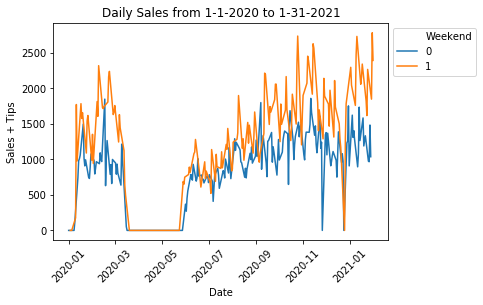

In [7]:
# assigning new `Weekend` column
daily_df = daily_df.assign(**{'Weekend': daily_df['Date'].apply(lambda x: 1 if x.weekday() in [4,5,6] else 0)})

# plotting
sns.lineplot(x='Date', y='Sales + Tips', hue='Weekend', data=daily_df)
plt.title('Daily Sales from 1-1-2020 to 1-31-2021');
plt.xticks(rotation=45);
plt.legend(bbox_to_anchor=(1,1))

#### Average Sales by Day of Week

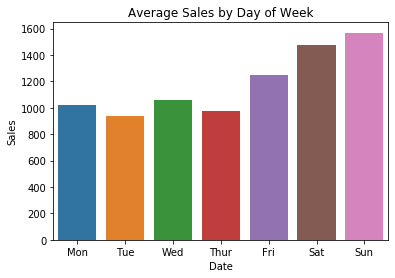

In [8]:
# only using values after COVID re-opening
temp = daily_df.copy()
temp = temp[temp['Date'] > pd.to_datetime('2020-05-28')]
temp['Date'] = temp['Date'].apply(lambda x: x.weekday())
temp = temp.groupby('Date')[['Sales']].agg('mean').reset_index()

sns.barplot(x='Date', y='Sales', data=temp)
plt.title('Average Sales by Day of Week');
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

#### Monthly Sales

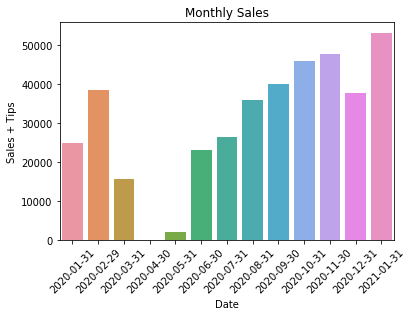

In [9]:
temp = daily_df.copy()
temp['Date'] = pd.DatetimeIndex(temp['Date'] - pd.to_timedelta(0, unit='d'))
temp = temp.groupby([pd.Grouper(key='Date', freq='M')]).agg('sum').reset_index().sort_values('Date')

sns.barplot(x='Date', y='Sales + Tips', data=temp)
plt.title('Monthly Sales')
plt.xticks(np.arange(len(temp['Date'])), [i.date() for i in temp['Date']], rotation=45);

#### <a id='Sec 3-1'>Monthly Sales Growth</a>

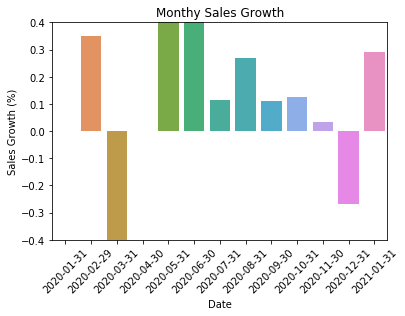

In [10]:
temp = daily_df.copy()
temp['Date'] = pd.DatetimeIndex(temp['Date'] - pd.to_timedelta(0, unit='d'))
temp = temp.groupby([pd.Grouper(key='Date', freq='M')])[['Sales']].agg('sum').reset_index()
temp = temp.assign(**{'Growth': (temp['Sales'] - temp['Sales'].shift(1)) / temp['Sales']})

sns.barplot(x='Date', y='Growth', data=temp)
plt.title('Monthy Sales Growth')
plt.xticks(np.arange(len(temp.index)), [i.date() for i in temp['Date']], rotation=45)
plt.ylabel('Sales Growth (%)')
plt.ylim(-.4, .4);

#### <a id='Sec 3-2'>Forecasting Monthly Sales</a>

In forecasting future monthly sales, we will adopt a naive approach by taking the average monthly sales growth (from after COVID re-opening) and applying it to a number of months in the future.

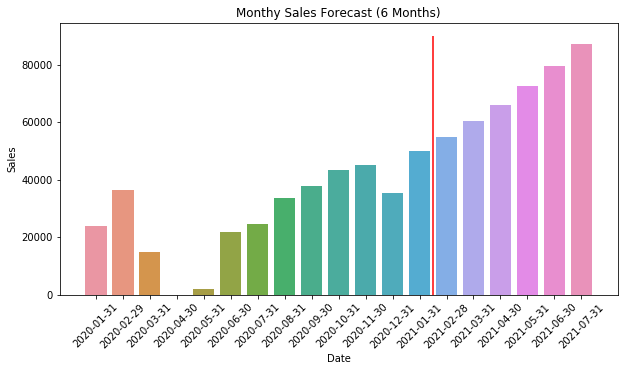

In [11]:
# getting average monthly sales growth
avg_growth = temp.loc[6:, 'Growth'].mean()

# multiplying sales by 1 + growth rate over 6 months
sales = (
    np.repeat(temp.loc[12,'Sales'], 6) * np.logspace(1,6,num=6,base=1+avg_growth)
)
growth = np.repeat(avg_growth, 6)
date = pd.date_range('2021-02-01', '2021-08-01', freq='M')

# concatening forecasted sales with current monthly sales
forecast = pd.DataFrame({'Date': date, 'Sales': sales, 'Growth': growth})
temp = pd.concat([temp, forecast])

# plotting
plt.figure(figsize = (10,5));
sns.barplot(x='Date', y='Sales', data=temp)
plt.title('Monthy Sales Forecast (6 Months)')
plt.xticks(np.arange(len(temp.index)), [i.date() for i in temp['Date']], rotation=45)
plt.ylabel('Sales')
plt.vlines(x=12.5, ymin=0, ymax=90000, color='red');

With this naive approach, we expect to reach **approximately \\$87300 in sales** by the end of July 2021.

#### Sales by Employee ID

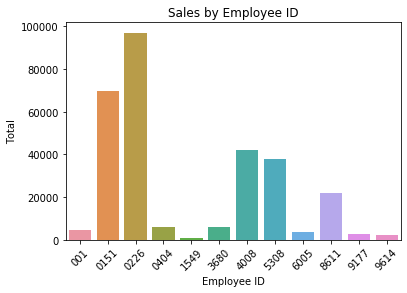

In [12]:
temp = hour_df.groupby('By')[['Total']].sum().reset_index()

sns.barplot(x='By', y='Total', data=temp)
plt.title('Sales by Employee ID')
plt.xlabel('Employee ID')
plt.xticks(rotation=45);

#### <a id='Sec 3-3'>Heatmap of Average Number of Sales by Hour of the Week</a>

In [13]:
# having a look at our hourly sales history
hour_df.head()

,Receipt #,Date,By,Total,Day,Hour
0,5585,2020-05-29 10:26:00,6005,2.56,4,10
1,5586,2020-05-29 10:29:00,6005,1.13,4,10
2,5587,2020-05-29 11:41:00,6005,10.00,4,11
3,5588,2020-05-29 11:43:00,6005,19.74,4,11
4,5589,2020-05-29 11:46:00,6005,5.33,4,11


In [14]:
n_days = -(hour_df.loc[0, 'Date'] - hour_df.loc[16435, 'Date']).days
hour_group = hour_df.groupby(['Day', 'Hour'])['Total'].agg(['sum', 'count']).reset_index().sort_values(by=['Day', 'Hour'], ascending=[True, True])

avg_sum = hour_group['sum'] / (n_days/7)
avg_count = hour_group['count'] / (n_days/7)
hour_group = hour_group.assign(**{'avg_sum': avg_sum, 'avg_count': avg_count})
hour_group.head()

,Day,Hour,sum,count,avg_sum,avg_count
0,0,11,2399.51,129,67.728105,3.641129
1,0,12,4786.12,286,135.092097,8.072581
2,0,13,3487.05,204,98.424798,5.758065
3,0,14,2806.07,167,79.203589,4.713710
4,0,15,2609.44,146,73.653548,4.120968


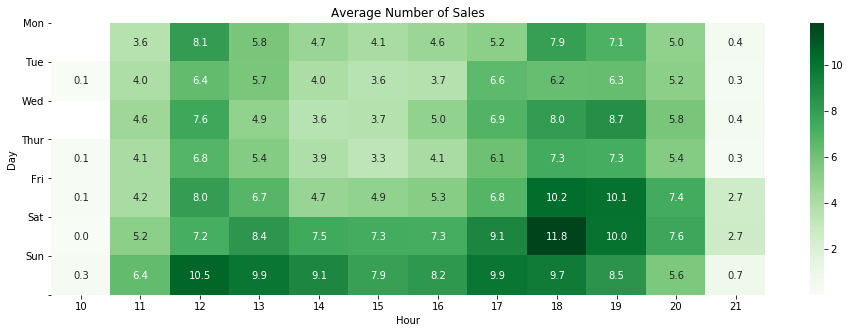

In [15]:
temp = pd.pivot_table(hour_group, values='avg_count', index='Day', columns='Hour')
plt.figure(figsize = (16,5))
sns.heatmap(temp, cmap='Greens', annot=True, fmt='.1f')
plt.title('Average Number of Sales');
plt.yticks(np.arange(8), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], rotation=0);

#### <a id='Sec 3-4'>Heatmap of Average Total Sales by Hour of the Week</a>

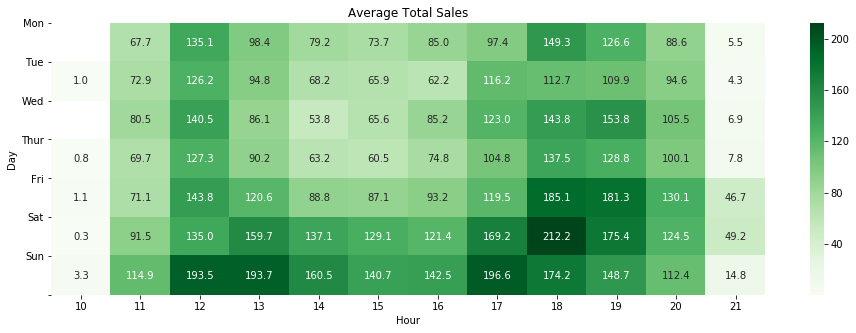

In [16]:
temp = pd.pivot_table(hour_group, values='avg_sum', index='Day', columns='Hour')
plt.figure(figsize = (16,5))
sns.heatmap(temp, cmap='Greens', annot=True, fmt='.1f')
plt.title('Average Total Sales');
plt.yticks(np.arange(8), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], rotation=0);

# 4) <a id='Sec 4'>Restaurant Analysis</a>
In this section, we have some primary goals, (1) and (2) of which were desired of by the restaurant owner herself:

**a) Determine how to reduce menu itemization while minimizing loss.**

**b) How to approach the pricing on certain menu items, namely rice and salad dishes.**

Finally as an observational aside, we will

**c) Determine whether or not tip amounts are statistically higher immediately after the onset of the COVID-19 pandemic.**

### a) <a id='Sec 4-1'>Reducing Menu Size</a>
In this section, we will reduce the menu size by looking at three particular items: **Egg Rolls**, **Chicken Skewers**, and **Firecracker Shrimp**. Currently, they have quantity choices for customers to choose from. A common complaint by the business owner is that it becomes hassling and awkward to clarify with the customer, "how many pieces would you like for...?" We will view previous months' sales history for these quantity choices to determine the optimal quantities.

In [17]:
# having a look at our appetizer choices
mod_df

,Appetizers,Month,Total
0,Chicken Skewers (2),2020-09-01,430.90
1,Chicken Skewers (2),2020-10-01,429.86
2,Chicken Skewers (2),2020-11-01,283.56
3,Chicken Skewers (3),2020-09-01,668.57
4,Chicken Skewers (3),2020-10-01,615.76
5,Chicken Skewers (3),2020-11-01,456.45
6,Egg Rolls (2),2020-09-01,837.80
7,Egg Rolls (2),2020-10-01,721.22
8,Egg Rolls (2),2020-11-01,706.12
9,Egg Rolls (3),2020-09-01,1252.75


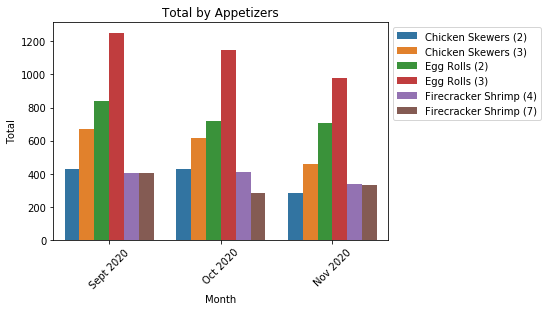

In [18]:
sns.barplot(x='Month', y='Total', hue='Appetizers', data=mod_df)
plt.title('Total by Appetizers')
plt.xticks([0,1,2], ['Sept 2020', 'Oct 2020', 'Nov 2020'], rotation=45);
plt.legend(bbox_to_anchor=(1, 1));

Viewing this new table we can see that consistently over the months of September 2020 to November 2020, Egg Rolls (3) and Chicken Skewers (3) make more than its other quantity; on average over the three months,

- Egg Rolls (3) make **\\$1,126.72** while Egg Rolls (2) make **\\$755.05**
- Chicken Skewers (3) make **\\$580.26** while Chicken Skewers (2) make **\\$381.44**

Therefore, it is advisable to drop the appetizer options with lower quantites and **retain the appetizer options with higher piece quantities**, i.e., "(3)" over "(2)". The only item that did not see this consistent trend was Firecracker Shrimp (4) and Firecracker Shrimp (7); on average:

- Firecracker Shrimp (7) make **\\$382.02** while Firecracker Shrimp (4) make **\\$339.45**

Therefore, it was suggested that the business owner could settle for whatever quantity she desired. She decided to go with an intermediate quantity of 5. These changes were **implemented in the month of December 2020**. Now we will look at the following month of **January 2021** to analyze the results.

In [19]:
best_01_21 = pd.read_csv('.\data\Best & Worst Sold Items 01-01-2021.csv')
best_01_21[best_01_21['Description'].str.strip().isin(['Egg Rolls (3)', 'Chicken Skewers (3)', 'Firecracker Shrimp (5)'])]

,Lookup Code,Description,Qty,Total (Tax included)
4,110054059,Egg Rolls (3),284,"2,117.42"
17,605023613,Chicken Skewers (3),105,"1,009.37"
19,826060240,Firecracker Shrimp (5),91,779.70


In the month of January 2021 *after* the itemization reduction, we see that the restaurant still **retains (and even exceeds) the aggregate earnings** of the *before* appetizer options, i.e., Egg Rolls (2) + Egg Rolls (3), Chicken Skewers (2) + Chicken Skewers (3). Now, the condensed appetizer menu with higher piece quantities make

- \\$2,117.42 or **12.52% more** for Egg Rolls
- \\$1,009.37 or **4.96% more** for Chicken Skewers

It appears that we have **reduced the menu size/options while simultaneously increasing profits** of these affected items by **12.52%** and **4.96%** for Egg Rolls and Chicken Skewers, respectively.

### b) <a id='Sec 4-2'>Price Changes</a>

Now we will investigate the pricing of rice and salad dishes of this restaurant in hopes of increasing revenue from these items. We will firstly look at the months July 2020 to November 2020 as a before metric and the month of January 2021 as an after metric. In this section, we are concerned with **Spicy Basil** dishes, **Saigon Rice Plate**, and **Vermicelli Salad**. The 
**prices of these items were decreased by \\$1 in December 2020**.

In [20]:
# having a look at our three items
best_df.head()

,Qty,Total,Item,Month
0,71,1026.14,Spicy Basil,2020-07-01
1,30,418.5,Saigon Rice Plate,2020-07-01
2,118,1559.39,Vermicelli Salad,2020-07-01
3,67,997.25,Spicy Basil,2020-08-01
4,97,1332.32,Saigon Rice Plate,2020-08-01


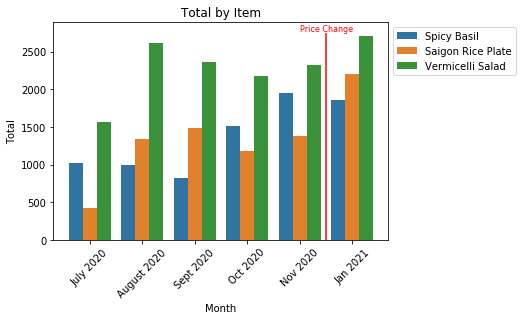

In [21]:
sns.barplot(x='Month', y='Total', hue='Item', data=best_df);
plt.title('Total by Item')
plt.xticks([0,1,2,3,4,5], ['July 2020', 'August 2020', 'Sept 2020', 'Oct 2020', 'Nov 2020', 'Jan 2021'], rotation=45);
plt.legend(bbox_to_anchor=(1, 1));
plt.vlines(x=4.5, ymin=0, ymax=2750, color='red');
plt.text(x=4, y=2775, s='Price Change', size=8, color='red');

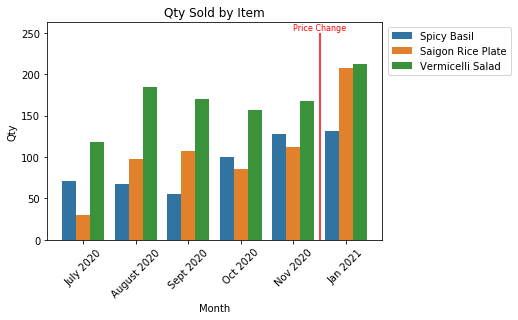

In [22]:
sns.barplot(x='Month', y='Qty', hue='Item', data=best_df);
plt.title('Qty Sold by Item')
plt.xticks([0,1,2,3,4,5], ['July 2020', 'August 2020', 'Sept 2020', 'Oct 2020', 'Nov 2020', 'Jan 2021'], rotation=45);
plt.legend(bbox_to_anchor=(1.4, 1));
plt.vlines(x=4.5, ymin=0, ymax=250, color='red');
plt.text(x=4, y=253, s='Price Change', size=8, color='red');

The takeaway from these two charts is that the price reduction of \\$1 in these three items did not lead to a clear increase in profit for Spicy Basil and Vermicelli Salad, however, it *did* for Saigon Rice. After the price change, Saigon Rice had a

- **Increase of \\$822.85 in total sales**
- **Increase of 95 in quantity sold**

### 3) <a id='Sec 4-3'>Customer Tip Before and After COVID-19</a>

We can grasp a general sense of customer support / gratitude by viewing customer `Tips` over time.

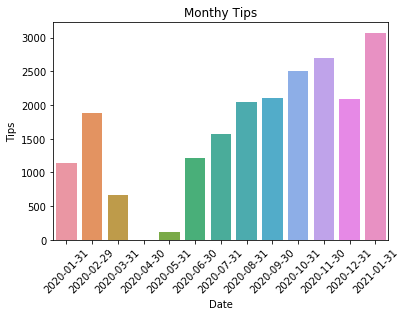

In [23]:
temp = daily_df.copy()
temp['Date'] = pd.DatetimeIndex(temp['Date'] - pd.to_timedelta(0, unit='d'))
temp = temp.groupby(pd.Grouper(key='Date', freq='M'))[['Tips']].agg('sum').reset_index()

sns.barplot(x='Date', y='Tips', data=temp)
plt.title('Monthy Tips')
plt.xticks(np.arange(len(temp.index)), [i.date() for i in temp['Date']], rotation=45);

This graph gives us a general sense of total customer support using weekly sum of `Tips` as a metric. Although sum of `Tips` gives us some information, it does not answer the question of whether or not a higher *proportion* of customers are supporting the restaurant over time.

#### Percentage of `Tips` of Total `Sales + Tips` by Day

We want to determine whether or not a higher *proportion* of customers are giving additional aid or support during or shortly after the large waves of COVID-19 cases. We can do this by redefining our approach and look at the **percentage of `Sales + Tips` that are tips**.

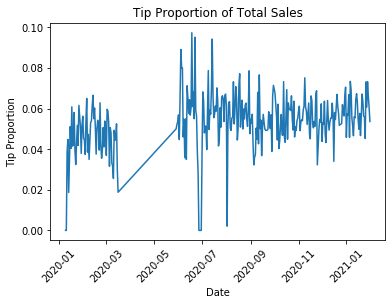

In [24]:
# creating new column for percentage of `Tips` of total `Sales + Tips`
prop_tips = daily_df['Tips'] / daily_df['Sales + Tips']
daily_df = daily_df.assign(**{'prop_tips': prop_tips})

# plotDf(daily_df, col='prop_tips', title='Proportion of Tips')
sns.lineplot(x='Date', y='prop_tips', data=daily_df)
plt.title('Tip Proportion of Total Sales');
plt.ylabel('Tip Proportion')
plt.xticks(rotation=45);

Seeing this graph, it appears that the proportion of `Tips` are in fact higher after the initial surge of COVID-19. In order to test this statistically, a **2-Sample T-Test**. We will use 1 month's worth of data before and after the closure of this restaurant. 

*Note: we will use after-restaurant-closure data from roughly August 2020 to September 2020 because the months preceeding have several outlying observations*

In [25]:
before = daily_df[(daily_df['Date'] > pd.to_datetime('January 15 2020')) & (daily_df['Date'] < pd.to_datetime('February 15 2020'))]
after = daily_df[(daily_df['Date'] > pd.to_datetime('August 2 2020')) & (daily_df['Date'] < pd.to_datetime('September 2 2020'))]

### 3 cont'd. Hypothesis Testing: 2-Sample T-Test

**Null Hypothesis**: The mean percentage of tips before the COVID-19 closure is the **same** as the mean percentage of tips after the COVID-19 closure.

**Alternative Hypothesis**: The mean percentage of tips after the COVID-19 closure **greater than** the mean percentage of tips before the COVID-19 closure.

We will use a significance level of **alpha = 0.05**.

In [26]:
# combining before and after statistics into a single dataframe for easier viewing
before_stats = before.describe().loc[['count', 'mean', 'std'], 'prop_tips']
after_stats = after.describe().loc[['count', 'mean', 'std'], 'prop_tips']
stats = pd.DataFrame({'before': before_stats, 'after': after_stats})
stats

,before,after
count,30.000000,30.000000
mean,0.048912,0.058789
std,0.009449,0.008897


#### Test Statistic

In [27]:
a_n = stats.loc['count', 'after']
a_mean = stats.loc['mean', 'after']
a_std = stats.loc['std', 'after']

b_n = stats.loc['count', 'before']
b_mean = stats.loc['mean', 'before']
b_std = stats.loc['std', 'before']

t_stat = (
    (a_mean - b_mean) / (np.sqrt(a_std**2/a_n + b_std**2/b_n))
)
t_stat

4.168159303241813

#### Observed p-value

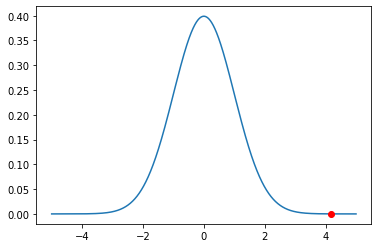

1.53534652498537e-05

In [28]:
x_axis = np.arange(-5, 5, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1))
plt.plot(t_stat,0,'ro')
plt.show()

norm.cdf(-t_stat)

#### Decision

With a **p-value of 1.535e-5 < 0.05, we reject our null hypothesis**. We found statistically significanty evidence that the true mean percentage of tips is **higher after the COVID-19 closure than before**.

# <a id='Sec 5'>Conclusion</a>

As a final result of our sales analysis, we were able to successfully

- **Reduce menu size** by condensing appetizer choices which saw a
    - **12.5% increase in sales** for Egg Rolls
    - **4.96% increase in sales** for Chicken Skewers
- **Adjust pricing** for rice and salad dishes in which only the **Saigon Rice Plate** saw significant positive changes such as a
    - **\\$822.85 increase in sales**
    - **95 increase in quantity sold**
    
Also using **inferential statistics**, we were able to determine that **tip proportions are significantly (p < 0.001) higher** post-COVID pandemic than pre-COVID pandemic, as intuitively expected.
    